# Air Pollution by Politics

## Imports & Installs

In [1]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
import json
from scipy.signal import argrelextrema

import sys
sys.path.append('../etc')
from refs import state_abbreviation_dict

! pip install xlrd
! pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


## Loads

Since the `data` folder is approximately **14 GB**, it has been uploaded to a **shared Google Drive folder**.
To access and use this data in this notebook, follow these steps:

---

### 1. Upload this notebook to **Google Colab**
- Open [Google Colab](https://colab.research.google.com/).
- Click on **File → Upload notebook** and select this notebook.

### 2. Mount your Google Drive
Insert and run the following code in a new Colab cell:

```python
from google.colab import drive
drive.mount('/content/drive')
```
- This will prompt you to authorize access to your Google Drive.

### 3. Create a Shortcut of the `data` Folder in Your Google Drive
- Open the shared Google Drive link.
- **Right-click** the `data` folder → **Add shortcut to Drive**.
- Choose a location inside your **MyDrive** (e.g., directly under "MyDrive" or inside a project folder).

### 4. Update the File Paths in the Notebook
When reading the data files, adjust the paths in your code to point to your shortcut location.
For example:

```python
import pandas as pd

# Example
presidential_data = pd.read_csv('/content/drive/MyDrive/your_folder_name/data/election/relevant/usa/1976-2020-president.csv')
```

Replace `your_folder_name` with the actual folder name where you added the shortcut.


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# presidential_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-president.csv')
# senate_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2020-senate.csv')
# house_data = pd.read_csv('/content/drive/MyDrive/School/data/election/relevant/usa/1976-2022-house.csv')
# house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')
#
# state_emissions_data = pd.read_excel(
#     "/content/drive/MyDrive/School/data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
#     engine="openpyxl",
#     skiprows=4
# )
#
# state_population_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/population_data.csv')
# state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
# state_land_size_data = pd.read_csv('/content/drive/MyDrive/School/data/general_state_data/state_sizes.csv')

In [4]:
presidential_data = pd.read_csv('../data/election/relevant/usa/1976-2020-president.csv')
senate_data = pd.read_csv('../data/election/relevant/usa/1976-2020-senate.csv')
house_data = pd.read_csv('../data/election/relevant/usa/1976-2022-house.csv')
house_data['party_simplified'] = house_data['party'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else 'OTHER')

state_emissions_data = pd.read_excel(
    "../data/co2_emissions/relevant/1970-2022-state_emissions.xlsx",
    engine="openpyxl",
    skiprows=4
)

state_population_size_data = pd.read_csv('../data/general_state_data/population_data.csv')
state_population_size_data.rename(columns={'AK': 'state', '1950': 'year', '135000': 'population'}, inplace=True)
state_land_size_data = pd.read_csv('../data/general_state_data/state_sizes.csv')

##  Analysis Per Category

### Election Analysis

This code calculates a political score for each U.S. state based on presidential, House, and Senate election data. It processes the election data for each year, calculates political scores by considering factors like vote percentage, longest streak of party wins, and the party of the most recent winner. It then combines these scores using weighted averages for each state and year. The final political scores are scaled and adjusted using the `MinMaxScaler`, and the scores are returned in a DataFrame, where each row represents a state’s political score for a specific year. This method provides insights into state-level political trends over time.

In [5]:
def calculate_scores_by_year(presidential_data, house_data, senate_data):
    years = sorted(presidential_data['year'].unique())
    all_scores = []

    for year in years:
        pres_results = calculate_political_scores(presidential_data, year)
        house_results = calculate_political_scores(house_data, year)
        sen_results = calculate_political_scores(senate_data, year)
        final_political_score = merge_and_average_scores(house_results, sen_results, pres_results, year)
        all_scores.append(final_political_score)

    return pd.concat(all_scores).reset_index(drop=True)

def calculate_political_scores(df, year=2020):
    df = df[df['year'] <= year].copy()  # Ensure a full copy is made
    df_filtered = df[df['party_simplified'].isin(['DEMOCRAT', 'REPUBLICAN'])].copy()

    df_filtered.loc[:, 'vote_percent'] = df_filtered['candidatevotes'] / df_filtered['totalvotes'] * 100

    df_winner = df_filtered.loc[df_filtered.groupby(['year', 'state'])['candidatevotes'].idxmax()].copy()

    state_streaks = {}
    for state in df_winner['state'].unique():
        state_data = df_winner[df_winner['state'] == state].sort_values('year')
        current_party = None
        streak = 0
        max_streak = 0
        last_winner = None

        for _, row in state_data.iterrows():
            if row['party_simplified'] == current_party:
                streak += 1
            else:
                current_party = row['party_simplified']
                streak = 1
            max_streak = max(max_streak, streak)
            last_winner = current_party

        state_streaks[state] = {'longest_streak': max_streak, 'last_winner': last_winner}

    df_summary = df_winner.groupby('state').agg(
        total_elections=('year', 'count'),
        avg_vote_percent=('vote_percent', 'mean'),
        last_winner=('party_simplified', 'last'),
        last_vote_percent=('vote_percent', 'last')
    ).reset_index()

    df_summary['longest_streak'] = df_summary['state'].map(lambda x: state_streaks[x]['longest_streak'])
    df_summary['streak_party'] = df_summary['state'].map(lambda x: state_streaks[x]['last_winner'])

    df_summary['party_numeric'] = df_summary['last_winner'].map({'REPUBLICAN': -1, 'DEMOCRAT': 1})

    features = df_summary[['longest_streak', 'avg_vote_percent', 'last_vote_percent']]

    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_summary.loc[:, ['streak_score', 'avg_vote_score', 'last_vote_score']] = scaler.fit_transform(features)

    df_summary['final_score'] = (df_summary['streak_score'] * 0.4 +
                                 df_summary['avg_vote_score'] * 0.3 +
                                 df_summary['last_vote_score'] * 0.3) * df_summary['party_numeric']
    df_summary['year'] = year
    return df_summary[['state', 'year', 'final_score']]

def merge_and_average_scores(house_results, sen_results, pres_results, year=2020):
    df_combined = house_results.merge(sen_results, on=['state', 'year'], suffixes=('_house', '_sen')) \
                               .merge(pres_results, on=['state', 'year'], suffixes=('', '_pres'))

    df_combined['final_score_avg'] = df_combined[['final_score_house', 'final_score_sen', 'final_score']].mean(axis=1)

    return df_combined[['state', 'year', 'final_score_avg']]

final_political_scores_by_year = calculate_scores_by_year(presidential_data, house_data, senate_data)
final_political_scores_by_year = final_political_scores_by_year.rename(columns={'final_score_avg':'party_affiliation_score'})
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


### Emissions Analysis

This code analyzes state-level emissions data by excluding any rows containing "Total" in the state name. It then calculates the average emissions for each state across the available years and identifies the top 10 states with the highest and lowest average emissions. The results are visualized in two separate bar charts: one for the top 10 states with the highest emissions, and another for the top 10 states with the lowest emissions, using red and green colors, respectively. These plots help to easily identify and compare the states based on their average emissions over time.

In [6]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


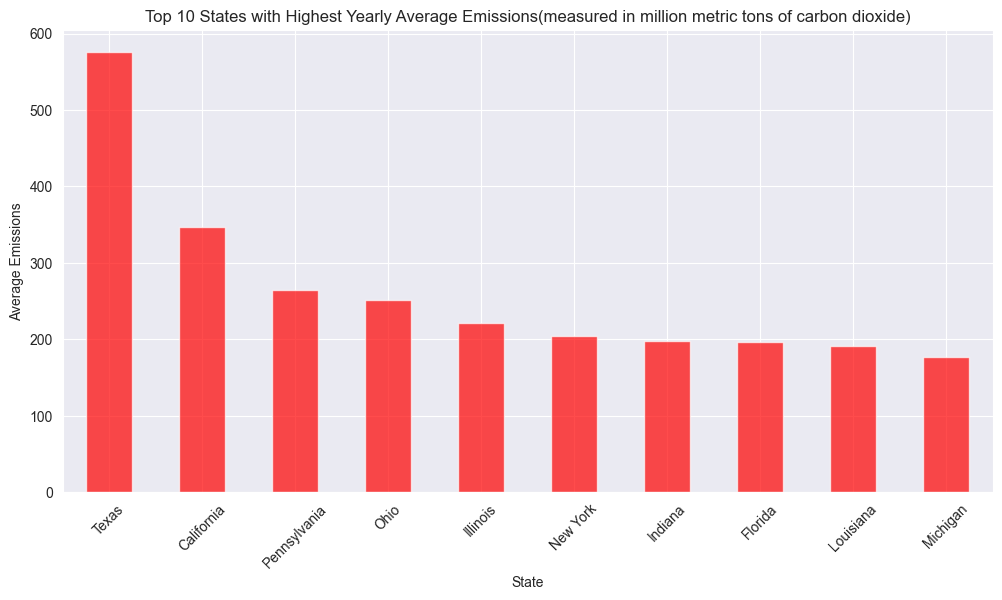

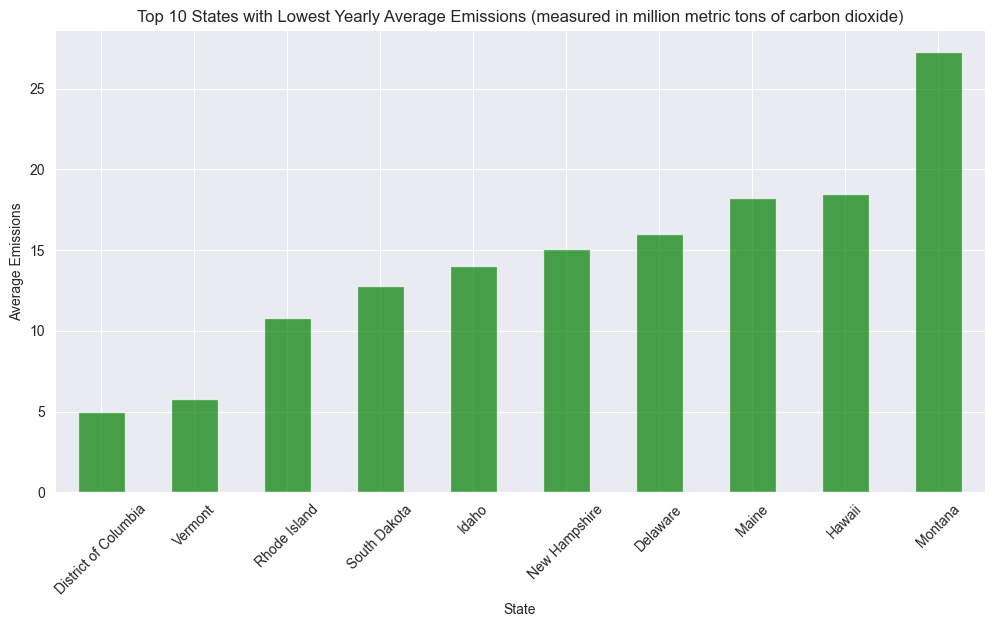

In [7]:
state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]
top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(10)
bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(10)

plt.figure(figsize=(12, 6))
top_states.plot(kind='bar', color='red', alpha=0.7)
plt.title("Top 10 States with Highest Yearly Average Emissions(measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
bottom_states.plot(kind='bar', color='green', alpha=0.7)
plt.title("Top 10 States with Lowest Yearly Average Emissions (measured in million metric tons of carbon dioxide)")
plt.xlabel("State")
plt.ylabel("Average Emissions")
plt.xticks(rotation=45)
plt.show()

This code analyzes and visualizes emissions data alongside political scores for U.S. states. It first filters out rows containing "Total" in the state name and then identifies the top and bottom 10 states based on their average emissions over time. For each of these states, it detects local minima and maxima in emissions using the `argrelextrema` function. It then plots emissions data over time, marking the local extrema points with blue (minima) and red (maxima) markers, while displaying corresponding political scores at each point. The `plot_emissions_with_extrema` function is used to generate two separate plots: one for the top 10 states with the highest emissions and another for the bottom 10 states with the lowest emissions. Additionally, the `extract_state_name` function extracts the state name from a given directory path. This comprehensive analysis helps in understanding the trends in emissions in relation to political scores over time.

In [8]:
def extract_state_name(base_directory):
    return os.path.basename(base_directory)

In [9]:
def analyze_and_plot_emissions(state_emissions_data, political_scores_data):
    # Remove rows that contain non-state information (like metadata or NaNs)
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Total", case=False, na=False)]
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].isna()]

    # Remove metadata rows that are not actual state names
    state_emissions_data = state_emissions_data[~state_emissions_data['State'].str.contains("Source:", na=False)]

    year_columns = [col for col in state_emissions_data.columns if isinstance(col, int)]

    # Get the top and bottom states based on average emissions over time
    top_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nlargest(5).index
    bottom_states = state_emissions_data.set_index('State')[year_columns].mean(axis=1).nsmallest(5).index

    # Filter data for the top and bottom states
    top_states_data = state_emissions_data[state_emissions_data['State'].isin(top_states)].set_index('State')[year_columns].T
    bottom_states_data = state_emissions_data[state_emissions_data['State'].isin(bottom_states)].set_index('State')[year_columns].T

    def find_local_extrema(data):
        extrema = {}
        for state in data.columns:
            emissions = data[state].values
            years = data.index.values
            local_min_idx = argrelextrema(emissions, np.less)[0]  # Indices of local minima
            local_max_idx = argrelextrema(emissions, np.greater)[0]  # Indices of local maxima
            extrema[state] = {
                "min": [(years[i], emissions[i]) for i in local_min_idx],  # Store (year, emission) pairs for mins
                "max": [(years[i], emissions[i]) for i in local_max_idx]   # Store (year, emission) pairs for max
            }
        return extrema

    top_extrema = find_local_extrema(top_states_data)
    bottom_extrema = find_local_extrema(bottom_states_data)

    def plot_emissions_with_extrema(data, extrema, title, scores_data):
        plt.figure(figsize=(12, 6))

        for state in data.columns:
            plt.plot(data.index, data[state], label=state)

            # Plot all local minima
            for x, y in extrema[state]["min"]:
                plt.scatter(x, y, color='blue', marker='v', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Min label with party affiliation score
                    plt.text(x, y - 0.2, f"Min {score[0]:.2f}", fontsize=9, verticalalignment='bottom', horizontalalignment='center')

            # Plot all local maxima
            for x, y in extrema[state]["max"]:
                plt.scatter(x, y, color='red', marker='^', zorder=5)
                # Convert both state names to uppercase for comparison
                score = scores_data[(scores_data['state'].str.upper() == state.upper()) & (scores_data['year'] == x)]['party_affiliation_score'].values
                if len(score) > 0:
                    # Display the Max label with party affiliation score
                    plt.text(x, y + 0.2, f"Max {score[0]:.2f}", fontsize=9, verticalalignment='top', horizontalalignment='center')

        plt.title(title)
        plt.xlabel("Year")
        plt.ylabel("Emissions")
        plt.legend(title="States", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
        plt.grid(True)
        plt.tight_layout()  # To ensure everything fits well without overlap
        plt.show()

    # Run the plot functions
    plot_emissions_with_extrema(top_states_data, top_extrema, "Top 5 States with Highest Emissions Over Time", political_scores_data)
    plot_emissions_with_extrema(bottom_states_data, bottom_extrema, "Top 5 States with Lowest Emissions Over Time", political_scores_data)

In [10]:
state_emissions_data

,State,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2017,2018,2019,2020,2021,2022,Percent,Absolute,Percent.1,Absolute.1
0,Alabama,102.717308,98.516403,104.984789,109.618074,108.831948,107.827892,108.123429,111.715385,106.665665,...,108.072106,111.907375,105.831211,97.977476,108.309051,109.291123,0.063999,6.573815,0.009067,0.982072
1,Alaska,11.358988,12.646215,13.435356,12.506009,12.793869,14.545277,15.991448,17.984787,19.530629,...,33.612044,34.392556,34.157534,35.915884,39.706281,41.304340,2.636269,29.945353,0.040247,1.598060
2,Arizona,24.937739,27.031606,30.257542,34.484241,36.772653,38.248535,43.806707,50.528150,49.310167,...,90.006330,93.647656,92.112163,79.678622,82.631087,81.426926,2.265209,56.489187,-0.014573,-1.204162
3,Arkansas,36.238491,35.147374,37.246511,40.904539,39.181082,36.417068,38.914652,41.698087,42.461084,...,63.822742,70.451214,64.778837,54.420762,61.727600,63.182542,0.743520,26.944050,0.023570,1.454942
4,California,294.672829,306.128867,313.001675,329.536275,304.727911,311.714448,327.104137,354.674419,345.358928,...,354.472039,356.680792,356.513198,301.963000,324.079546,326.205361,0.107009,31.532531,0.006560,2.125815
5,Colorado,43.057661,43.628581,47.509428,51.112474,50.519445,51.833807,55.165689,58.339998,58.471686,...,88.166320,89.412318,91.099265,79.264087,84.663258,88.685173,1.059684,45.627512,0.047505,4.021915
6,Connecticut,47.839723,45.901611,47.222932,48.585809,45.433967,41.695952,43.441472,43.059846,43.977977,...,33.707466,37.239556,36.494940,33.652811,36.331574,37.041873,-0.225709,-10.797851,0.019550,0.710299
7,Delaware,16.051567,15.907361,15.991638,17.221577,16.636428,15.518162,16.131819,16.116363,16.162534,...,13.712744,13.932115,13.540875,12.158646,12.659583,12.664988,-0.210981,-3.386579,0.000427,0.005405
8,District of Columbia,13.642245,11.877348,11.306110,11.850583,9.849625,7.890092,7.690561,7.922985,7.450558,...,2.578868,2.851156,2.799149,2.393873,2.581308,2.645821,-0.806057,-10.996424,0.024992,0.064513
9,Florida,104.403707,111.555148,121.728053,132.294566,124.346429,125.987894,134.577618,138.240436,146.157945,...,237.368371,240.946920,232.630532,206.725204,225.411105,231.001254,1.212577,126.597547,0.024800,5.590150


In [11]:
final_political_scores_by_year

,state,year,party_affiliation_score
0,ARIZONA,1976,-0.276792
1,CALIFORNIA,1976,0.787895
2,CONNECTICUT,1976,0.701563
3,DELAWARE,1976,0.269130
4,FLORIDA,1976,-0.464138
...,...,...,...
578,VIRGINIA,2020,-0.162847
579,WASHINGTON,2020,0.024978
580,WEST VIRGINIA,2020,-0.181551
581,WISCONSIN,2020,-0.268129


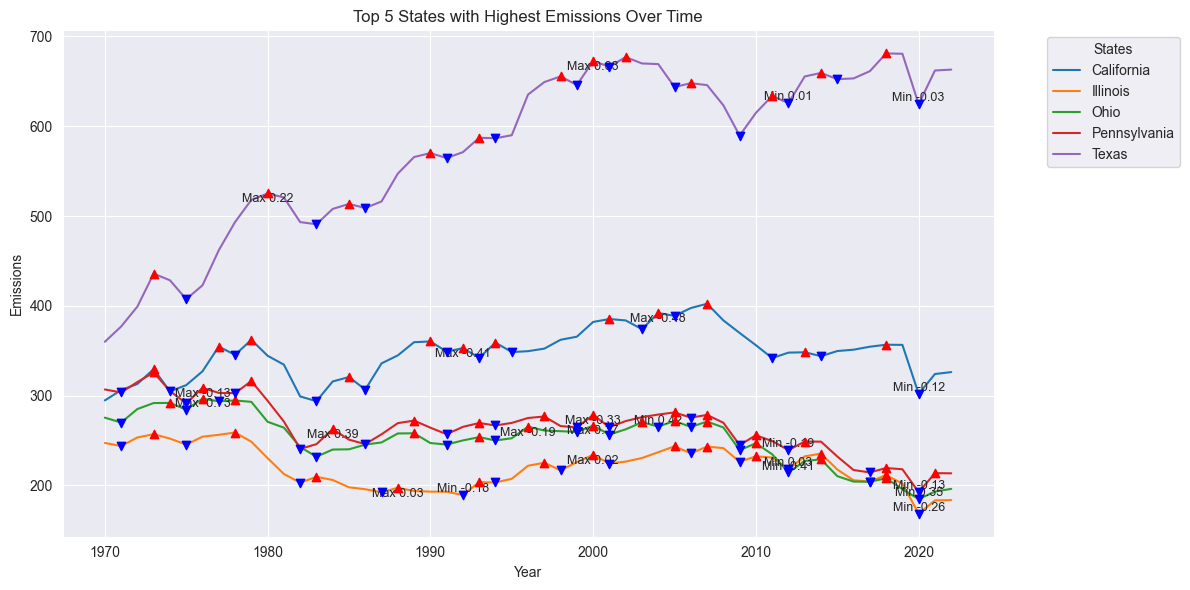

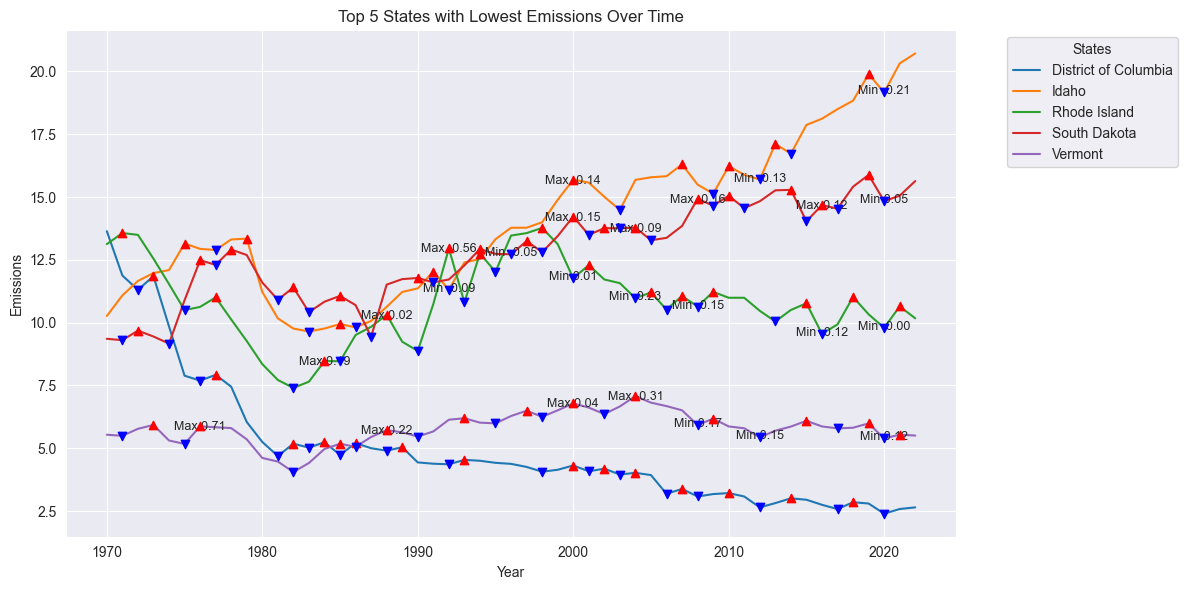

In [12]:
analyze_and_plot_emissions(state_emissions_data, final_political_scores_by_year)

### Demographic and Size Additions

This code performs data transformation and merging to create a comprehensive dataset for analysis. It starts by melting the `state_emissions_data` to reshape it, converting column names to lowercase and standardizing state names using a dictionary (`state_abbreviation_dict`). It then filters the data to include only valid years and merges it with `state_population_size_data` based on state and year. The `state_land_size_data` is also processed and merged to include land size information. Afterward, the political score data (`final_political_scores_by_year`) is integrated into the dataset by standardizing state names and performing another merge. The final result is a merged dataset (`final_merged_dataset`) containing emissions, population size, land size, and political scores for each state and year, ready for further analysis.

In [13]:
state_emissions_melted = state_emissions_data.melt(id_vars=["State"],
                                                   var_name="Year",
                                                   value_name="Emissions")
state_emissions_melted.columns = state_emissions_melted.columns.str.lower()
state_emissions_melted = state_emissions_melted.applymap(lambda x: x.lower() if isinstance(x, str) else x)

state_emissions_melted["state"] = state_emissions_melted["state"].map(state_abbreviation_dict)

state_emissions_melted["year"] = state_emissions_melted["year"].astype(str)
state_emissions_melted = state_emissions_melted.dropna(subset=["year"])  # Remove NaNs
state_emissions_melted = state_emissions_melted[state_emissions_melted["year"].str.isnumeric()]  # Keep only numeric years

state_emissions_melted["year"] = state_emissions_melted["year"].astype(int)
state_population_size_data["year"] = state_population_size_data["year"].astype(int)

merged_population_and_emission_data = state_emissions_melted.merge(state_population_size_data, on=["state", "year"], how="inner")

state_land_size_data = state_land_size_data.rename(columns={"State": "state"})
state_land_size_data["state"] = state_land_size_data["state"].str.lower().map(state_abbreviation_dict)

merged_size_population_emissions_data = merged_population_and_emission_data.merge(state_land_size_data, on="state", how="inner")
merged_size_population_emissions_data = merged_size_population_emissions_data.rename(columns={"Size (Square Miles)": "size"})

final_political_scores_by_year["state"] = final_political_scores_by_year["state"].str.lower().map(state_abbreviation_dict)

final_merged_dataset = merged_size_population_emissions_data.merge(final_political_scores_by_year, on=["state", "year"], how="inner")

final_merged_dataset

,state,year,emissions,population,size,party_affiliation_score
0,AL,1980,107.172609,3900368,52420,0.707140
1,AL,1984,95.389801,3951820,52420,0.365180
2,AL,1988,105.221571,4023844,52420,0.121370
3,AL,1992,120.975301,4139269,52420,0.225649
4,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...
578,WY,2004,64.383683,509106,97813,-0.206691
579,WY,2008,67.222540,546043,97813,-0.211750
580,WY,2012,66.647098,576656,97813,-0.260097
581,WY,2016,61.035090,585243,97813,-0.280461


### Bills Analysis

This code processes environmental bills and votes data across multiple directories to calculate a "Final Score" for each state and year. It begins by loading JSON files for bills and votes, normalizing and merging the data, and calculating the percentage of "yes" votes for each bill. The code identifies climate-related bills by checking for specific environmental terms in the bill description, calculates a weighted climate score based on vote percentages, and sums these scores to get the final score. The code is designed to process files for all states and years in a directory structure, aggregating the results into a final DataFrame. It also measures the execution time and saves the results to a CSV file. The final output provides a dataset of average "Final Scores" by year and state, reflecting the states' environmental legislative activity over time.

In [14]:
def process_bills_and_votes(bill_directory, vote_directory, environmental_terms):
    def load_json_files_from_directory(directory_path):
        data_list = []
        if os.path.exists(directory_path) and os.listdir(directory_path):
            for filename in os.listdir(directory_path):
                if filename.endswith(".json"):
                    with open(os.path.join(directory_path, filename), 'r') as file:
                        data = json.load(file)
                        df = pd.json_normalize(data)
                        data_list.append(df)
            return pd.concat(data_list, ignore_index=True) if data_list else pd.DataFrame()
        return pd.DataFrame()

    bill_df = load_json_files_from_directory(bill_directory)
    if bill_df.empty:
        return 0

    bill_df.columns = [col.split('.')[-1] for col in bill_df.columns]

    vote_df = load_json_files_from_directory(vote_directory)
    if vote_df.empty:
        return 0

    vote_df.columns = [col.split('.')[-1] for col in vote_df.columns]

    merged_df = pd.merge(bill_df, vote_df, on="bill_id", how="outer")
    merged_df = merged_df.drop_duplicates(subset='bill_id', keep='first')
    merged_df['percent_yes'] = merged_df['yea'] / merged_df['total']
    merged_df = merged_df[['percent_yes', 'bill_id', 'title', 'description']].reset_index().drop(columns=['index'])

    merged_df['climate'] = merged_df['description'].apply(lambda x: 1 if any(term.lower() in str(x).lower() for term in environmental_terms) else 0)
    merged_df.fillna(0)

    climate_ratio = merged_df['climate'].sum() / len(merged_df) if len(merged_df) > 0 else 0
    merged_df['weighted_climate'] = climate_ratio * merged_df['percent_yes']
    final_score = merged_df['weighted_climate'].sum()

    return final_score

def process_all_files(base_directory, environmental_terms):
    year = os.path.basename(base_directory).split('-')[0]
    file_dict = {}

    vote_dir = os.path.join(base_directory, 'vote')
    bill_dir = os.path.join(base_directory, 'bill')

    file_dict[year] = process_bills_and_votes(bill_dir, vote_dir, environmental_terms)

    df = pd.DataFrame(list(file_dict.items()), columns=['Year', 'Final_Score'])
    return df

def process_all_states(base_directory, environmental_terms):
    results = []
    for subdir in os.listdir(base_directory):
        subdir_path = os.path.join(base_directory, subdir)
        print(subdir_path)
        if os.path.isdir(subdir_path):
            subdirectory_df = process_all_files(subdir_path, environmental_terms)
            results.append(subdirectory_df)

    state = extract_state_name(base_directory)
    final_df = pd.concat(results, ignore_index=True)
    final_df['State'] = state
    return final_df

def process_all_directories(base_directory, environmental_terms):
    all_results = []
    state_count = 1

    for state_dir in os.listdir(base_directory):
        print(f"{state_count}: Processing state: {state_dir}")
        state_count+=1
        state_dir_path = os.path.join(base_directory, state_dir)

        if os.path.isdir(state_dir_path):
            state_df = process_all_states(state_dir_path, environmental_terms)
            all_results.append(state_df)

    final_df = pd.concat(all_results, ignore_index=True)
    final_df = final_df.sort_values('Year').reset_index().drop(columns=['index'])
    final_df = final_df.groupby(['Year', 'State'])['Final_Score'].mean().reset_index()

    return final_df

def process_all_directories_timed(base_directory, environmental_terms):
    start_time = time.time()

    results_df = process_all_directories(base_directory, environmental_terms)

    end_time = time.time()
    execution_time = end_time - start_time
    results_df.to_csv('data/results/election_scores.csv')
    print(f"Execution Time: {execution_time} seconds")

    return results_df

In [15]:
# DON'T RUN - TAKES HOURS TO TERMINATE
# results_df = process_all_directories_timed('data/bills', environmental_terms)
# results_df

This code processes the election scores data by reading a CSV file and cleaning the data by removing unnecessary columns and sorting by year and state. It then maps state abbreviations using a dictionary (`state_abbreviation_dict`). The data is grouped into four-year periods (starting from 2008), and the policy scores for each state are aggregated by summing the "Final_Score" within each year group. The resulting DataFrame is renamed to "Policy Scores" and contains aggregated scores by year group and state.

In [16]:
election_scores_df = pd.read_csv('../data/results/election_scores.csv')
election_scores_df = election_scores_df.drop(columns=['Unnamed: 0'])
election_scores_df = election_scores_df.sort_values(by=['Year', 'State'], ascending=True)
election_scores_df['State'] = election_scores_df['State'].map(state_abbreviation_dict)

start_year = 2008
election_scores_df['Year_Group'] = (election_scores_df['Year'] - start_year) // 4 * 4 + start_year
aggregated_scores_df = election_scores_df.groupby(['Year_Group', 'State'], as_index=False)['Final_Score'].sum()
aggregated_scores_df = aggregated_scores_df.rename(columns={'Final_Score': 'Policy Scores'})
aggregated_scores_df

,Year_Group,State,Policy Scores
0,2004,OH,0.000000
1,2004,PA,0.000000
2,2008,AK,0.000000
3,2008,AL,1.972585
4,2008,AR,23.282568
...,...,...,...
163,2024,TN,11.959624
164,2024,UT,1.664631
165,2024,VT,0.018692
166,2024,WA,14.846776


This code merges the `aggregated_scores_df` with `final_merged_dataset` based on matching year groups and states, using a right join to ensure all records from `final_merged_dataset` are included. It then drops the columns "State" and "Year_Group" and resets the index, cleaning up the final DataFrame. The resulting `final_df` contains the combined data with the aggregated policy scores and corresponding values from the merged dataset.

In [17]:
final_df = aggregated_scores_df.merge(final_merged_dataset,
                                       left_on=['Year_Group', 'State'],
                                       right_on=['year', 'state'],
                                       how='right')
final_df = final_df.drop(columns=['State', 'Year_Group']).reset_index().drop(columns='index')
final_df

,Policy Scores,state,year,emissions,population,size,party_affiliation_score
0,NaN,AL,1980,107.172609,3900368,52420,0.707140
1,NaN,AL,1984,95.389801,3951820,52420,0.365180
2,NaN,AL,1988,105.221571,4023844,52420,0.121370
3,NaN,AL,1992,120.975301,4139269,52420,0.225649
4,NaN,AL,1996,137.217372,4290403,52420,0.015759
...,...,...,...,...,...,...,...
578,NaN,WY,2004,64.383683,509106,97813,-0.206691
579,3.146390,WY,2008,67.222540,546043,97813,-0.211750
580,14.832834,WY,2012,66.647098,576656,97813,-0.260097
581,12.360478,WY,2016,61.035090,585243,97813,-0.280461


This code identifies the numerical and categorical columns in the `final_df` DataFrame by selecting columns with `float64` and `int64` data types for numerical columns, and excluding them for categorical columns. It then applies a K-Nearest Neighbors (KNN) imputer to fill any missing values in the numerical columns, using 5 neighbors to estimate the missing data. The imputed values are applied to a copy of `final_df`, resulting in a new DataFrame (`final_df_imputed`) with the missing numerical data filled in.

In [18]:
numerical_columns = final_df.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = final_df.select_dtypes(exclude=['float64', 'int64']).columns

imputer = KNNImputer(n_neighbors=5)

final_df_imputed = final_df.copy()
final_df_imputed[numerical_columns] = imputer.fit_transform(final_df_imputed[numerical_columns])

final_df_dropped = final_df.dropna(axis=0)

final_df_imputed, final_df_dropped

(     Policy Scores state    year   emissions  population     size  \
 0        27.000440    AL  1980.0  107.172609   3900368.0  52420.0   
 1        42.097413    AL  1984.0   95.389801   3951820.0  52420.0   
 2        42.097413    AL  1988.0  105.221571   4023844.0  52420.0   
 3        27.183586    AL  1992.0  120.975301   4139269.0  52420.0   
 4        17.721870    AL  1996.0  137.217372   4290403.0  52420.0   
 ..             ...   ...     ...         ...         ...      ...   
 578       7.146112    WY  2004.0   64.383683    509106.0  97813.0   
 579       3.146390    WY  2008.0   67.222540    546043.0  97813.0   
 580      14.832834    WY  2012.0   66.647098    576656.0  97813.0   
 581      12.360478    WY  2016.0   61.035090    585243.0  97813.0   
 582       5.390857    WY  2020.0   55.385165    577681.0  97813.0   
 
      party_affiliation_score  
 0                   0.707140  
 1                   0.365180  
 2                   0.121370  
 3                   0.225649 

In [19]:
def fill_missing_years(df):
    df['year'] = df['year'].astype(int)
    max_year = min(df['year'].max(), 2024)
    full_years = pd.DataFrame({'year': range(df['year'].min(), max_year + 1)})
    states = df['state'].unique()
    filled_df = []

    for state in states:
        state_df = df[df['state'] == state]
        state_df = pd.merge(full_years, state_df, on='year', how='left')
        state_df['state'] = state
        for col in ['Policy Scores', 'emissions', 'population', 'size', 'party_affiliation_score']:
            state_df[col] = state_df[col].interpolate(method='linear', limit_direction='both')
        filled_df.append(state_df)

    return pd.concat(filled_df).reset_index(drop=True)

In [20]:
final_df_imputed = fill_missing_years(final_df_imputed)
final_df_imputed

,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,1976,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
1,1977,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
2,1978,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
3,1979,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
4,1980,27.000440,AL,107.172609,3900368.0,52420.0,0.707140
...,...,...,...,...,...,...,...
2245,2016,12.360478,WY,61.035090,585243.0,97813.0,-0.280461
2246,2017,10.618073,WY,59.622609,583352.5,97813.0,-0.287553
2247,2018,8.875667,WY,58.210128,581462.0,97813.0,-0.294644
2248,2019,7.133262,WY,56.797646,579571.5,97813.0,-0.301735


In [21]:
final_df_dropped = fill_missing_years(final_df_dropped)
final_df_dropped

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,Policy Scores,state,emissions,population,size,party_affiliation_score
0,2004,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
1,2005,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
2,2006,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
3,2007,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
4,2008,1.972585,AL,139.355377,4718206.0,52420.0,-0.108467
...,...,...,...,...,...,...,...
624,2016,12.360478,WY,61.035090,585243.0,97813.0,-0.280461
625,2017,10.618073,WY,59.622609,583352.5,97813.0,-0.287553
626,2018,8.875667,WY,58.210128,581462.0,97813.0,-0.294644
627,2019,7.133262,WY,56.797646,579571.5,97813.0,-0.301735


#### Prepare Full Data

This code creates a copy of the `final_df_imputed` DataFrame and applies standardization to the selected columns. It first identifies the columns to normalize by excluding "state," "year," and "emissions" from the list of columns. Then, it uses the `StandardScaler` from `sklearn.preprocessing` to normalize these columns, transforming them to have a mean of 0 and a standard deviation of 1. The transformed data is assigned back to the corresponding columns in the `final_df_imputed` DataFrame, resulting in the normalized dataset.

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

def normalize_data(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    scaler = StandardScaler()
    columns_to_normalize = [col for col in df.columns if col not in exclude_columns]
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])
    return df

final_df_imputed_normalized = normalize_data(final_df_imputed)
final_df_dropped_normalized = normalize_data(final_df_dropped)

In [23]:
state_emissions_melted = state_emissions_melted.dropna()
state_emissions_melted

,state,year,emissions
0,AL,1970,102.717308
1,AK,1970,11.358988
2,AZ,1970,24.937739
3,AR,1970,36.238491
4,CA,1970,294.672829
...,...,...,...
2854,VA,2022,96.233942
2855,WA,2022,74.701895
2856,WV,2022,79.179688
2857,WI,2022,90.591835


In [24]:
final_df_imputed_normalized = final_df_imputed_normalized.copy()
final_df_imputed_normalized.set_index(['state', 'year'], inplace=True)
state_emissions_melted.set_index(['state', 'year'], inplace=True)

final_df_imputed_normalized['emissions'] = state_emissions_melted['emissions']

final_df_imputed_normalized.reset_index(inplace=True)
state_emissions_melted.reset_index(inplace=True)
final_df_imputed_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score
0,AL,1976,0.385287,108.123429,-0.260609,-0.244045,0.707140
1,AL,1977,0.385287,111.715385,-0.260609,-0.244045,0.707140
2,AL,1978,0.385287,106.665665,-0.260609,-0.244045,0.707140
3,AL,1979,0.385287,111.618240,-0.260609,-0.244045,0.707140
4,AL,1980,0.385287,107.172609,-0.260609,-0.244045,0.707140
...,...,...,...,...,...,...,...
2245,WY,2016,-0.288220,61.035090,-0.808000,0.227085,-0.280461
2246,WY,2017,-0.368379,62.583762,-0.808312,0.227085,-0.287553
2247,WY,2018,-0.448537,63.639323,-0.808624,0.227085,-0.294644
2248,WY,2019,-0.528696,58.897673,-0.808936,0.227085,-0.301735


In [25]:
final_df_dropped_normalized = final_df_dropped_normalized.copy()
final_df_dropped_normalized.set_index(['state', 'year'], inplace=True)
state_emissions_melted.set_index(['state', 'year'], inplace=True)

final_df_dropped_normalized['emissions'] = state_emissions_melted['emissions']

final_df_dropped_normalized.reset_index(inplace=True)
state_emissions_melted.reset_index(inplace=True)

final_df_dropped_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score
0,AL,2004,-0.576684,141.975194,-0.227362,-0.297275,-0.108467
1,AL,2005,-0.576684,143.531689,-0.227362,-0.297275,-0.108467
2,AL,2006,-0.576684,145.768689,-0.227362,-0.297275,-0.108467
3,AL,2007,-0.576684,147.286933,-0.227362,-0.297275,-0.108467
4,AL,2008,-0.576684,139.355377,-0.227362,-0.297275,-0.108467
...,...,...,...,...,...,...,...
624,WY,2016,-0.279498,61.035090,-0.788170,0.120018,-0.280461
625,WY,2017,-0.329346,62.583762,-0.788426,0.120018,-0.287553
626,WY,2018,-0.379194,63.639323,-0.788683,0.120018,-0.294644
627,WY,2019,-0.429043,58.897673,-0.788939,0.120018,-0.301735


Emissions initially declined, then rose steadily until the early 2000s, after which they began a continuous downward trend.

    year   emissions
0   1976   93.737515
1   1977   96.500934
2   1978   97.334440
3   1979   98.717193
4   1980   95.144842
5   1981   92.723631
6   1982   87.861297
7   1983   87.467112
8   1984   91.930208
9   1985   91.999663
10  1986   92.058266
11  1987   95.078238
12  1988   99.671862
13  1989  101.144680
14  1990  100.327565
15  1991   99.386259
16  1992  101.288180
17  1993  103.182156
18  1994  104.600861
19  1995  105.889315
20  1996  109.851460
21  1997  111.294663
22  1998  111.974872
23  1999  113.261021
24  2000  117.117254
25  2001  114.923910
26  2002  115.624927
27  2003  117.050857
28  2004  119.010031
29  2005  119.520495
30  2006  117.968544
31  2007  119.772586
32  2008  115.888839
33  2009  107.629638
34  2010  111.463404
35  2011  108.664135
36  2012  104.260472
37  2013  106.744099
38  2014  107.855380
39  2015  104.798473
40  2016  102.938219
41  2017  102.237081
42  2018  105.286101
43  2019  102.639411
44  2020   91.391576


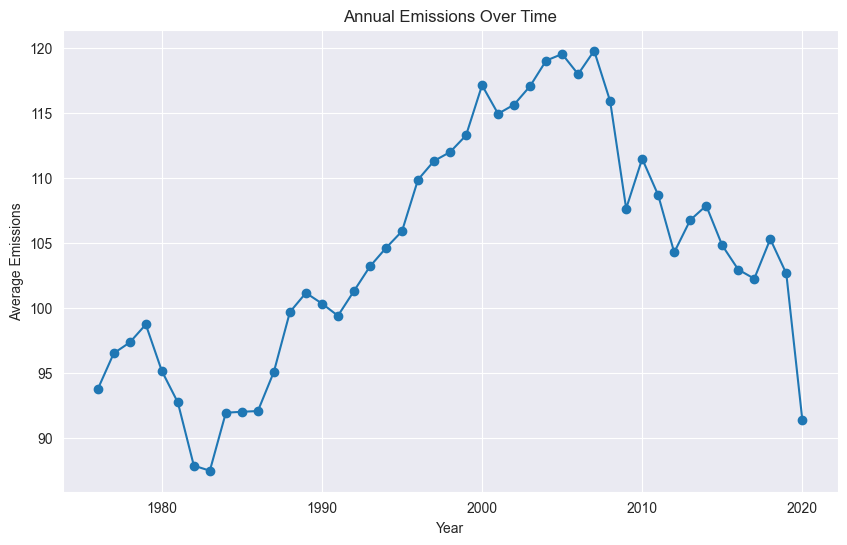

In [26]:
# Group emissions by year and calculate the mean
emissions_by_year = final_df_imputed_normalized.groupby('year')['emissions'].mean().reset_index()

# Display the table
print(emissions_by_year)

# Plot emissions over time
plt.figure(figsize=(10, 6))
plt.plot(emissions_by_year['year'], emissions_by_year['emissions'], marker='o')
plt.title('Annual Emissions Over Time')
plt.xlabel('Year')
plt.ylabel('Average Emissions')
plt.grid(True)
plt.show()

Average absolute change in national emissions year-over-year: 2.4745
Average total emissions per year: 104.3380
Change as percentage of average total emissions: 2.37%


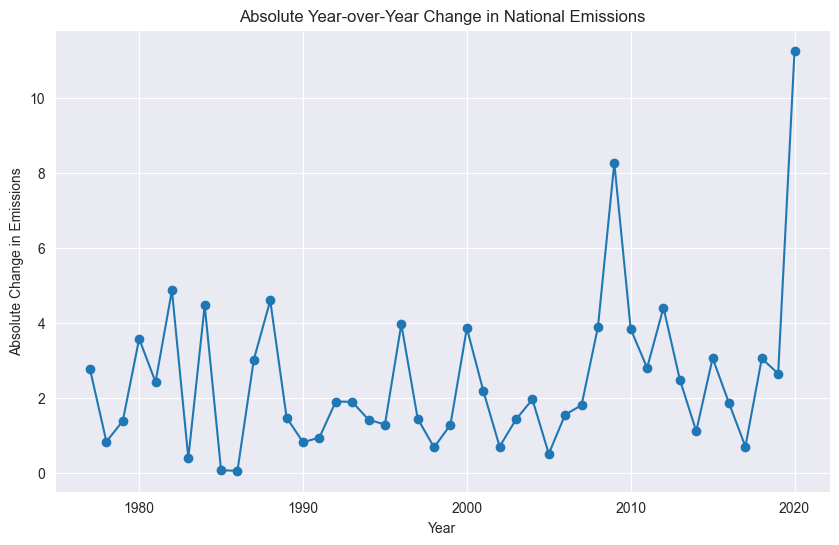

In [27]:
overall_yearly_mean = final_df_imputed_normalized.groupby('year')['emissions'].mean().rename('overall_mean')

overall_yearly_mean = overall_yearly_mean.sort_index()
yearly_changes = overall_yearly_mean.diff().dropna()
average_yearly_change = yearly_changes.abs().mean()
average_total_emissions = overall_yearly_mean.mean()
change_percentage = (average_yearly_change / average_total_emissions) * 100

print(f"Average absolute change in national emissions year-over-year: {average_yearly_change:.4f}")
print(f"Average total emissions per year: {average_total_emissions:.4f}")
print(f"Change as percentage of average total emissions: {change_percentage:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(yearly_changes.index, yearly_changes.abs(), marker='o')
plt.title('Absolute Year-over-Year Change in National Emissions')
plt.xlabel('Year')
plt.ylabel('Absolute Change in Emissions')
plt.grid(True)
plt.show()


## Final Analysis

### Current Emissions Predictions

This code trains a Random Forest model to predict emissions using various features such as "Policy Scores," "population," "size," "party_affiliation_score," and state-specific columns. It splits the data into training and testing sets, trains the model, and makes predictions on the test set. The Mean Squared Error (MSE) is calculated to evaluate the model's performance, and the execution time of the process is also recorded and printed. The final output includes the MSE and the time taken to train and test the model.

In [28]:
def train_rf_model(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    label_encoder = LabelEncoder()
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    state_columns = df.columns[6:]
    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    elapsed_time = time.time() - start_time

    feature_importance = rf_model.feature_importances_
    features = X.columns
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    print(f'Time taken: {elapsed_time} seconds')

    print("\nFeature Importance:")
    print(feature_importance_df)

    return mse, r2, elapsed_time, feature_importance_df

#### Imputed

In [29]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed = train_rf_model(final_df_imputed)

Mean Squared Error: 55.640970235628885
R² Score: 0.9954210970616708
Time taken: 0.48989009857177734 seconds

Feature Importance:
                   Feature  Importance
1               population    0.735744
2                     size    0.252251
0            Policy Scores    0.004663
4  party_affiliation_score    0.002534
5          political_party    0.002489
3  party_affiliation_score    0.002319


#### Non-imputed

In [30]:
mse_dropped, r2_dropped, elapsed_time_dropped, feature_importance_dropped = train_rf_model(final_df_dropped)

Mean Squared Error: 17.49127538599002
R² Score: 0.998071170334396
Time taken: 0.15805530548095703 seconds

Feature Importance:
                   Feature  Importance
1               population    0.883169
2                     size    0.079224
0            Policy Scores    0.020792
3  party_affiliation_score    0.007490
5          political_party    0.006419
4  party_affiliation_score    0.002906


This code trains a Linear Regression model to predict emissions using features such as "Policy Scores," "population," "size," "party_affiliation_score," and state-specific columns. The dataset is divided into training and testing sets, and the model is fitted using the training data. After generating predictions on the test set, the Mean Squared Error (MSE) and R² score are calculated to assess the model’s accuracy. The time taken to train and evaluate the model is also recorded. Additionally, the model's feature coefficients are displayed, and a plot is generated showing the actual vs. predicted emissions, including a red regression line to visualize the fit.

In [31]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

def train_lr_model(df, exclude_columns=["state", "year", "emissions", "party_affiliation_score"]):
    label_encoder = LabelEncoder()
    df['political_party'] = label_encoder.fit_transform(df['party_affiliation_score'])

    state_columns = df.columns[6:]
    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score'] + list(state_columns)]
    y = df['emissions']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    start_time = time.time()
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    y_pred = lr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    elapsed_time = time.time() - start_time

    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lr_model.coef_
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    print(f'Mean Squared Error: {mse}')
    print(f'R² Score: {r2}')
    print(f'Time taken: {elapsed_time} seconds')

    print("\nFeature Coefficients:")
    print(coef_df)

    # Plotting predicted vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    # Regression line
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_test, p(y_test), "r--", label='Regression Line')
    plt.xlabel('Actual Emissions')
    plt.ylabel('Predicted Emissions')
    plt.title('Linear Regression: Actual vs Predicted Emissions')
    plt.legend()
    plt.grid(True)
    plt.show()

    return mse, r2, elapsed_time, coef_df


#### Imputed

Mean Squared Error: 2825.119085356289
R² Score: 0.767510414964252
Time taken: 0.005942106246948242 seconds

Feature Coefficients:
                   Feature  Coefficient
1               population    94.934587
0            Policy Scores   -20.323748
2                     size     9.778187
4  party_affiliation_score     3.399416
3  party_affiliation_score     3.399416
5          political_party     0.017170


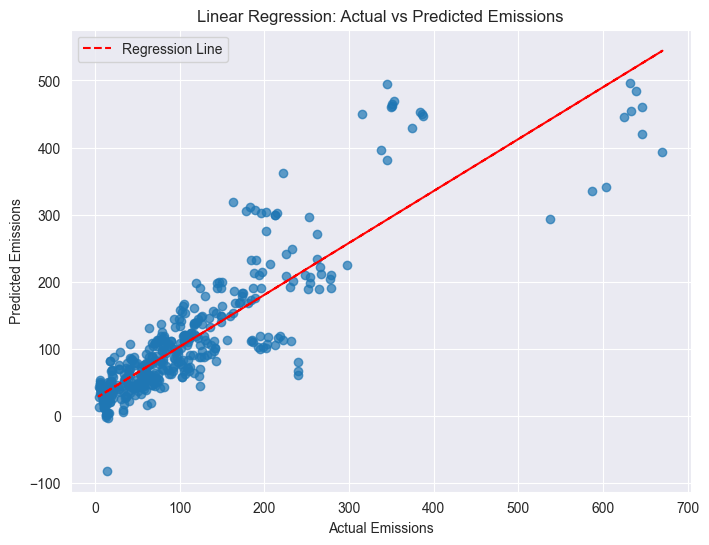

In [32]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed = train_lr_model(final_df_imputed)

#### Non-imputed

Mean Squared Error: 2630.290669363681
R² Score: 0.7099478133942276
Time taken: 0.003052949905395508 seconds

Feature Coefficients:
                   Feature  Coefficient
1               population   122.816409
4  party_affiliation_score   -81.977093
3  party_affiliation_score   -81.977093
0            Policy Scores   -37.173899
2                     size     7.543019
5          political_party     0.319769


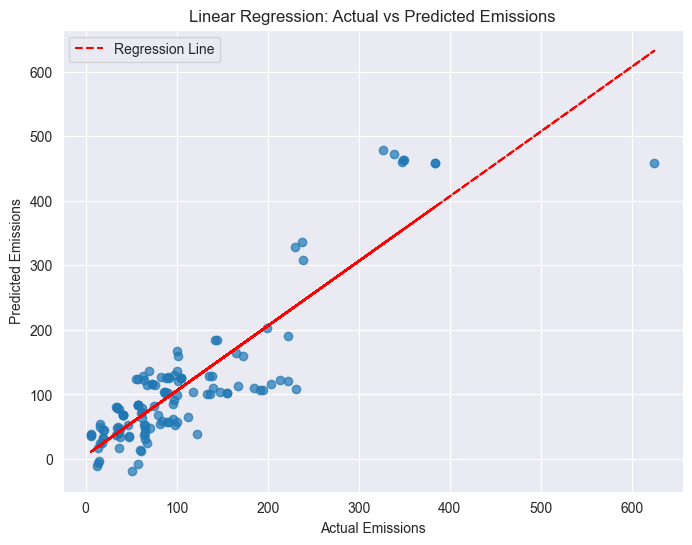

In [33]:
mse_imputed, r2_imputed, elapsed_time_imputed, feature_importance_imputed = train_lr_model(final_df_dropped)

### Future Predictions

This code splits the data into 10-year intervals and trains a Random Forest model to predict emissions for each interval. It calculates predictions and compares them with actual emissions, evaluating the model's performance using Mean Squared Error (MSE) and R² score. The actual and predicted emissions are plotted over the years, and the model performance metrics are displayed. The final output is a DataFrame showing the actual and predicted emissions for each year.

In [34]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def train_random_forest(df, window_size, n_splits=5):
    try:
        df['year'] = pd.to_numeric(df['year'], errors='coerce')

        if 'state' not in df.columns:
            print("No 'state' column found!")
            return

        df = df.sort_values(['state', 'year'])

        # Create lag features for sliding window
        lagged_dfs = []
        for lag in range(1, window_size + 1):
            lagged = df[['state', 'year', 'emissions']].copy()
            lagged['year'] += lag
            lagged.rename(columns={'emissions': f'emissions_t_minus_{lag}'}, inplace=True)
            lagged_dfs.append(lagged)

        for lagged in lagged_dfs:
            df = df.merge(lagged, on=['state', 'year'], how='inner')

        df = df.dropna()
        if df.empty:
            print("No data after sliding window merge.")
            return

        print(f"Shape after sliding window processing: {df.shape}")

        features = [f'emissions_t_minus_{i}' for i in range(window_size, 0, -1)] + \
                   ['Policy Scores', 'population', 'size', 'party_affiliation_score']

        X = df[features]
        y = df['emissions']

        # Time Series Cross Validation
        tscv = TimeSeriesSplit(n_splits=n_splits)
        r2_scores = []
        mse_scores = []

        for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
            rf_model.fit(X_train, y_train)
            y_pred = rf_model.predict(X_test)

            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)

            print(f"Fold {fold} — R²: {r2:.4f}, MSE: {mse:.4f}")
            r2_scores.append(r2)
            mse_scores.append(mse)

        print(f"\nAverage R² Score: {np.mean(r2_scores):.4f}")
        print(f"Average Mean Squared Error: {np.mean(mse_scores):.4f}")

        # Feature importances from final model
        feature_importances = rf_model.feature_importances_
        feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

        return r2_scores, mse_scores, feature_df

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Debugging details:")
        print(f"DataFrame shape before: {df.shape}")
        print(f"Columns: {df.columns}")
        print(f"window_size: {window_size}")


In [35]:
final_df_imputed

,year,Policy Scores,state,emissions,population,size,party_affiliation_score,political_party
0,1976,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140,2175
1,1977,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140,2175
2,1978,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140,2175
3,1979,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140,2175
4,1980,0.385287,AL,107.172609,-0.260609,-0.244045,0.707140,2175
...,...,...,...,...,...,...,...,...
2245,2016,-0.288220,WY,61.035090,-0.808000,0.227085,-0.280461,322
2246,2017,-0.368379,WY,59.622609,-0.808312,0.227085,-0.287553,309
2247,2018,-0.448537,WY,58.210128,-0.808624,0.227085,-0.294644,294
2248,2019,-0.528696,WY,56.797646,-0.808936,0.227085,-0.301735,273


#### Imputed

In [36]:
train_random_forest(final_df_imputed, 1)

Shape after sliding window processing: (2200, 9)
Fold 1 — R²: 0.9081, MSE: 577.9345
Fold 2 — R²: 0.9973, MSE: 8.8064
Fold 3 — R²: 0.9980, MSE: 4.7918
Fold 4 — R²: 0.9929, MSE: 64.0520
Fold 5 — R²: 0.7940, MSE: 6339.1346

Average R² Score: 0.9381
Average Mean Squared Error: 1398.9439


([0.9081365827334501,
  0.9973022066989335,
  0.9980394640964653,
  0.9928809737776638,
  0.7940351743829592],
 [577.9344951875981,
  8.806381331105532,
  4.791822411896982,
  64.05197038936814,
  6339.134592622751],
                    Feature  Importance
 0      emissions_t_minus_1    0.992896
 2               population    0.003396
 3                     size    0.003205
 4  party_affiliation_score    0.000272
 1            Policy Scores    0.000230)

In [37]:
train_random_forest(final_df_imputed, 5)

Shape after sliding window processing: (2000, 13)
Fold 1 — R²: 0.9462, MSE: 341.9805
Fold 2 — R²: 0.9977, MSE: 7.3386
Fold 3 — R²: 0.9982, MSE: 4.1519
Fold 4 — R²: 0.9932, MSE: 59.1093
Fold 5 — R²: 0.7902, MSE: 6658.1403

Average R² Score: 0.9451
Average Mean Squared Error: 1414.1441


([0.9462132975168028,
  0.9977227360694042,
  0.998170364286065,
  0.9931990548363157,
  0.7902032647660345],
 [341.9804735146254,
  7.338560223710412,
  4.151887759275699,
  59.1093114650187,
  6658.140278896812],
                    Feature  Importance
 4      emissions_t_minus_1    0.990794
 7                     size    0.002241
 3      emissions_t_minus_2    0.001929
 6               population    0.001355
 2      emissions_t_minus_3    0.001259
 1      emissions_t_minus_4    0.001236
 0      emissions_t_minus_5    0.000932
 5            Policy Scores    0.000132
 8  party_affiliation_score    0.000123)

In [38]:
train_random_forest(final_df_imputed, 9)

Shape after sliding window processing: (1800, 17)
Fold 1 — R²: 0.9620, MSE: 245.5132
Fold 2 — R²: 0.9972, MSE: 9.0109
Fold 3 — R²: 0.9979, MSE: 4.7073
Fold 4 — R²: 0.9914, MSE: 73.6146
Fold 5 — R²: 0.7793, MSE: 7207.1036

Average R² Score: 0.9456
Average Mean Squared Error: 1507.9899


([0.9620268964274693,
  0.9972071426446143,
  0.9978897789050327,
  0.9913912123658756,
  0.779316889256571],
 [245.51322476336102,
  9.010882735004593,
  4.7072752145515935,
  73.6145569852953,
  7207.103566140354],
                     Feature  Importance
 8       emissions_t_minus_1    0.984696
 11                     size    0.002894
 7       emissions_t_minus_2    0.002731
 1       emissions_t_minus_8    0.002071
 0       emissions_t_minus_9    0.002049
 5       emissions_t_minus_4    0.001438
 3       emissions_t_minus_6    0.001315
 6       emissions_t_minus_3    0.001043
 2       emissions_t_minus_7    0.000735
 4       emissions_t_minus_5    0.000477
 10               population    0.000314
 12  party_affiliation_score    0.000121
 9             Policy Scores    0.000116)

#### Non-imputed

In [39]:
train_random_forest(final_df_dropped, 1)

Shape after sliding window processing: (592, 9)
Fold 1 — R²: 0.5841, MSE: 2651.6342
Fold 2 — R²: 0.9889, MSE: 40.6776
Fold 3 — R²: 0.9952, MSE: 5.6646
Fold 4 — R²: 0.5755, MSE: 15126.9268
Fold 5 — R²: 0.9976, MSE: 17.7552

Average R² Score: 0.8283
Average Mean Squared Error: 3568.5317


([0.5841485484085256,
  0.9889294815303015,
  0.9952264154422822,
  0.5754663992630596,
  0.9975836706938744],
 [2651.634190228187,
  40.6776010542643,
  5.664642130642768,
  15126.926827636229,
  17.75521986502715],
                    Feature  Importance
 0      emissions_t_minus_1    0.778644
 2               population    0.128032
 3                     size    0.080618
 1            Policy Scores    0.010093
 4  party_affiliation_score    0.002613)

In [40]:
train_random_forest(final_df_dropped, 2)

Shape after sliding window processing: (555, 10)
Fold 1 — R²: 0.7113, MSE: 1818.8676
Fold 2 — R²: 0.9898, MSE: 36.5886
Fold 3 — R²: 0.9937, MSE: 7.4958
Fold 4 — R²: 0.5926, MSE: 14466.5597
Fold 5 — R²: 0.9974, MSE: 20.4015

Average R² Score: 0.8570
Average Mean Squared Error: 3269.9826


([0.7113475351798029,
  0.9897988153600527,
  0.9936568945620246,
  0.5926029903157701,
  0.9973639613474535],
 [1818.8675952021085,
  36.5886287335382,
  7.4958018216392315,
  14466.559706975959,
  20.40148207128223],
                    Feature  Importance
 1      emissions_t_minus_1    0.466072
 0      emissions_t_minus_2    0.308166
 3               population    0.179389
 4                     size    0.034466
 2            Policy Scores    0.008943
 5  party_affiliation_score    0.002964)

In [41]:
train_random_forest(final_df_dropped, 3)

Shape after sliding window processing: (518, 11)
Fold 1 — R²: 0.7152, MSE: 1769.9405
Fold 2 — R²: 0.9908, MSE: 32.1096
Fold 3 — R²: 0.9904, MSE: 11.3043
Fold 4 — R²: 0.6030, MSE: 14040.7510
Fold 5 — R²: 0.9975, MSE: 20.6285

Average R² Score: 0.8594
Average Mean Squared Error: 3174.9468


([0.7152192846669783,
  0.9907843284116311,
  0.9903861025673371,
  0.6029590899734776,
  0.9974797185235265],
 [1769.9405256017947,
  32.109583143762855,
  11.304325037192447,
  14040.750965341165,
  20.628498276034026],
                    Feature  Importance
 2      emissions_t_minus_1    0.329583
 4               population    0.214520
 0      emissions_t_minus_3    0.206956
 1      emissions_t_minus_2    0.197707
 5                     size    0.039635
 3            Policy Scores    0.009991
 6  party_affiliation_score    0.001608)

### Unsupervised Analysis

This code creates a new column, "political_party," in the `final_df_imputed` DataFrame. It assigns the value 'D' (Democrat) if the "final_score_avg" is greater than 0, and 'R' (Republican) if it is less than or equal to 0. The resulting DataFrame reflects the political party assignment based on the final scores.

In [42]:
final_df_imputed_normalized['political_party'] = final_df_imputed_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
final_df_imputed_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score,political_party
0,AL,1976,0.385287,108.123429,-0.260609,-0.244045,0.707140,D
1,AL,1977,0.385287,111.715385,-0.260609,-0.244045,0.707140,D
2,AL,1978,0.385287,106.665665,-0.260609,-0.244045,0.707140,D
3,AL,1979,0.385287,111.618240,-0.260609,-0.244045,0.707140,D
4,AL,1980,0.385287,107.172609,-0.260609,-0.244045,0.707140,D
...,...,...,...,...,...,...,...,...
2245,WY,2016,-0.288220,61.035090,-0.808000,0.227085,-0.280461,R
2246,WY,2017,-0.368379,62.583762,-0.808312,0.227085,-0.287553,R
2247,WY,2018,-0.448537,63.639323,-0.808624,0.227085,-0.294644,R
2248,WY,2019,-0.528696,58.897673,-0.808936,0.227085,-0.301735,R


In [43]:
final_df_dropped_normalized['political_party'] = final_df_dropped_normalized['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')

final_df_dropped_normalized

,state,year,Policy Scores,emissions,population,size,party_affiliation_score,political_party
0,AL,2004,-0.576684,141.975194,-0.227362,-0.297275,-0.108467,R
1,AL,2005,-0.576684,143.531689,-0.227362,-0.297275,-0.108467,R
2,AL,2006,-0.576684,145.768689,-0.227362,-0.297275,-0.108467,R
3,AL,2007,-0.576684,147.286933,-0.227362,-0.297275,-0.108467,R
4,AL,2008,-0.576684,139.355377,-0.227362,-0.297275,-0.108467,R
...,...,...,...,...,...,...,...,...
624,WY,2016,-0.279498,61.035090,-0.788170,0.120018,-0.280461,R
625,WY,2017,-0.329346,62.583762,-0.788426,0.120018,-0.287553,R
626,WY,2018,-0.379194,63.639323,-0.788683,0.120018,-0.294644,R
627,WY,2019,-0.429043,58.897673,-0.788939,0.120018,-0.301735,R


This code processes the data by assigning political party labels based on the `party_affiliation_score` and then performs Principal Component Analysis (PCA) to reduce the data to two components, visualizing the results in a scatter plot with political party color coding. It then trains a Support Vector Machine (SVM) classifier using the two PCA components to predict political party affiliation, evaluating the model with accuracy and a confusion matrix, and visualizing the confusion matrix with a heatmap. Additionally, the code calculates and visualizes the correlation matrix for selected features to assess their relationships and calculates the Variance Inflation Factor (VIF) to check for multicollinearity among the features, providing insights into potential issues in the dataset.

In [44]:
def analyze_political_party(df):
    if 'party_affiliation_score' not in df.columns:
        df['party_affiliation_score'] = 0

    X = df[['Policy Scores', 'population', 'size', 'party_affiliation_score']]
    X_scaled = StandardScaler().fit_transform(X)

    pca_result = PCA(n_components=2).fit_transform(X_scaled)
    pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
    pca_df['political_party'] = df['political_party']
    pca_df['party_affiliation_score'] = df['party_affiliation_score']

    pca_df['political_party'] = pca_df['political_party'].fillna(
        pca_df['party_affiliation_score'].apply(lambda x: 'D' if x > 0 else 'R')
    )

    plt.figure(figsize=(10, 6))
    colors = {'D': 'blue', 'R': 'red'}
    plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c=pca_df['political_party'].apply(lambda x: colors[x]), alpha=0.7)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Political Parties')
    plt.grid(True)
    plt.legend(['Democrat', 'Republican'])
    plt.show()

    X_pca = pca_df[['PCA1', 'PCA2']]
    y = pca_df['political_party']

    pca_df = pca_df.dropna(subset=['political_party'])

    X_pca = pca_df[['PCA1', 'PCA2']]
    y = pca_df['political_party']

    svm_model = SVC(kernel='linear', random_state=42)
    svm_model.fit(X_pca, y)

    y_pred = svm_model.predict(X_pca)

    accuracy = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)

    print(f'Accuracy: {accuracy}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Democrat', 'Republican'], yticklabels=['Democrat', 'Republican'])
    plt.title('Confusion Matrix')
    plt.show()

    correlation_matrix = df[['Policy Scores', 'population', 'size', 'party_affiliation_score']].corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

    X_with_const = add_constant(X)
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X_with_const.columns
    vif_data['VIF'] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

    print(vif_data)


#### Imputed

In [45]:
without_party_score_df = final_df_imputed_normalized.drop(columns='party_affiliation_score')

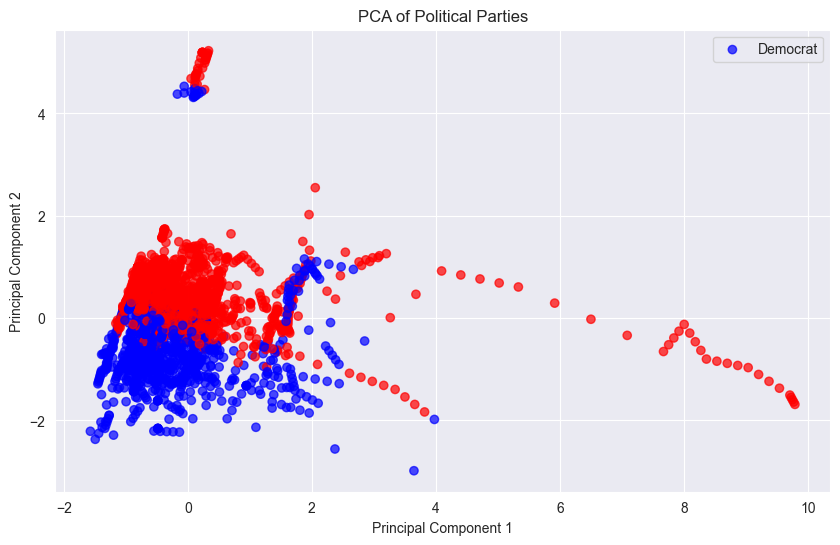

Accuracy: 0.8746666666666667


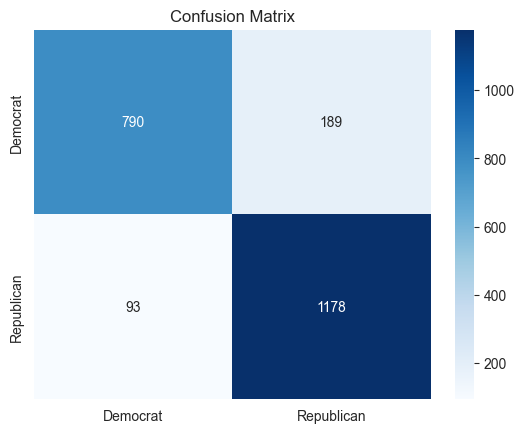

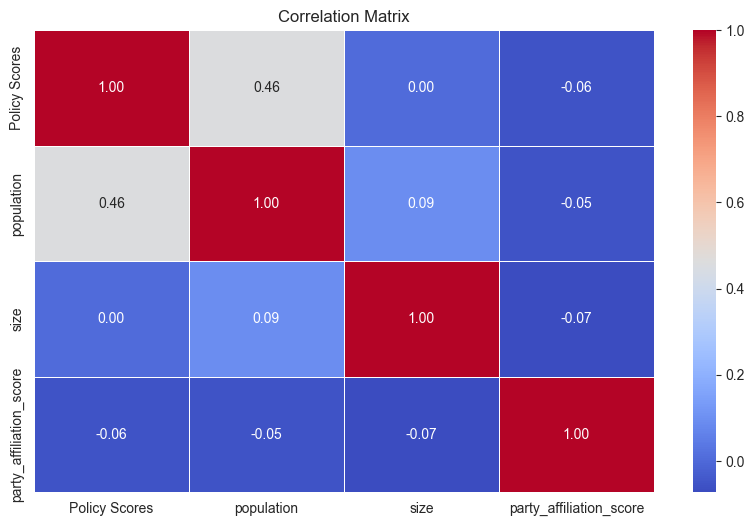

                   Feature       VIF
0                    const  1.012563
1            Policy Scores  1.268167
2               population  1.278269
3                     size  1.015748
4  party_affiliation_score  1.008898


In [46]:
analyze_political_party(final_df_imputed_normalized)

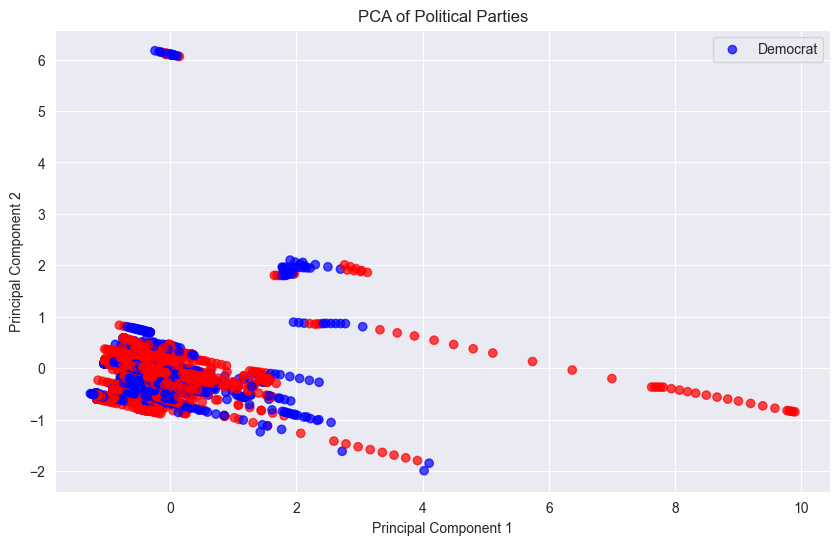

Accuracy: 0.5648888888888889


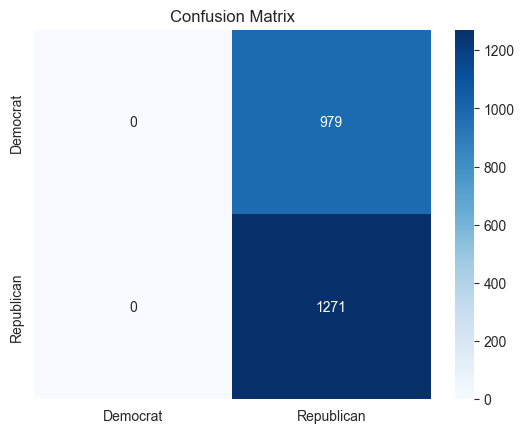

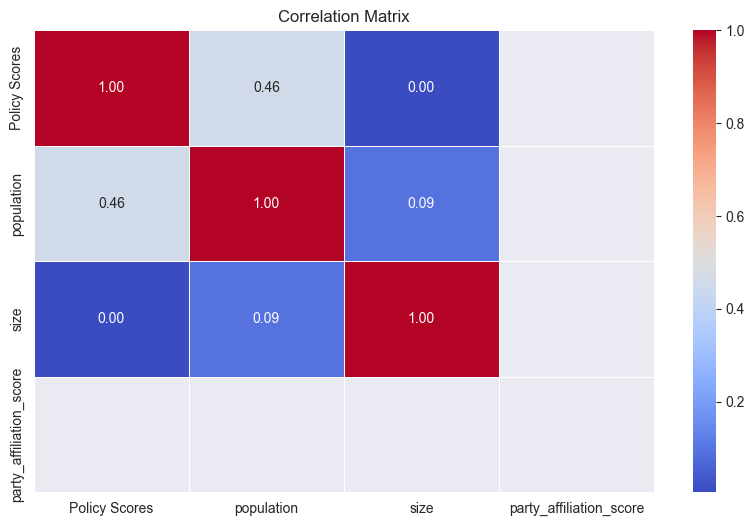

                   Feature       VIF
0                    const  1.000000
1            Policy Scores  1.266308
2               population  1.277582
3                     size  1.010805
4  party_affiliation_score       NaN


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [47]:
analyze_political_party(without_party_score_df)

#### Non-imputed

In [48]:
without_party_score_df = final_df_dropped_normalized.drop(columns='party_affiliation_score')

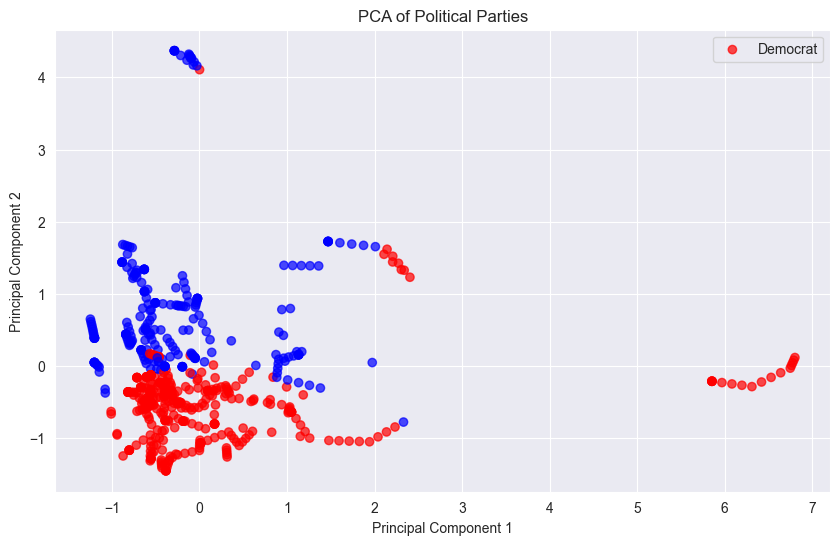

Accuracy: 0.9236883942766295


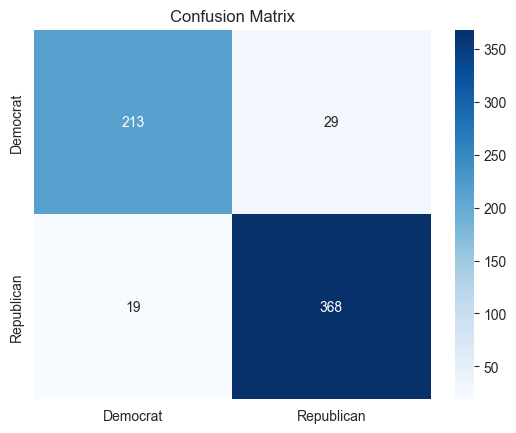

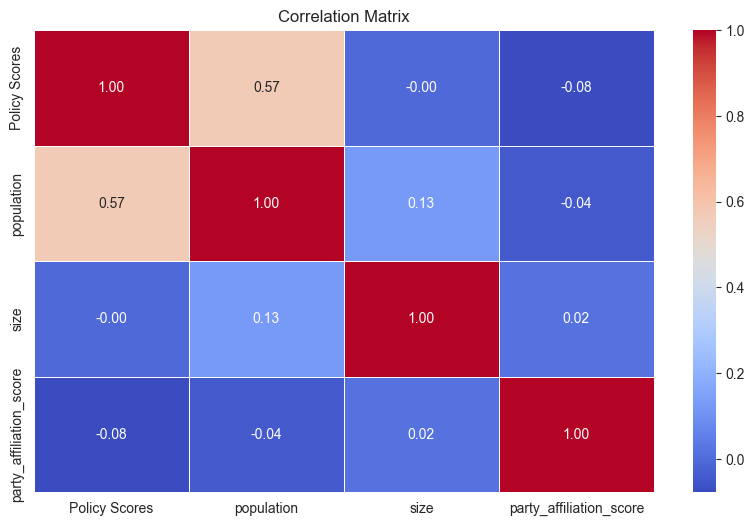

                   Feature       VIF
0                    const  1.035322
1            Policy Scores  1.491595
2               population  1.509379
3                     size  1.024679
4  party_affiliation_score  1.006232


In [49]:
analyze_political_party(final_df_dropped_normalized)

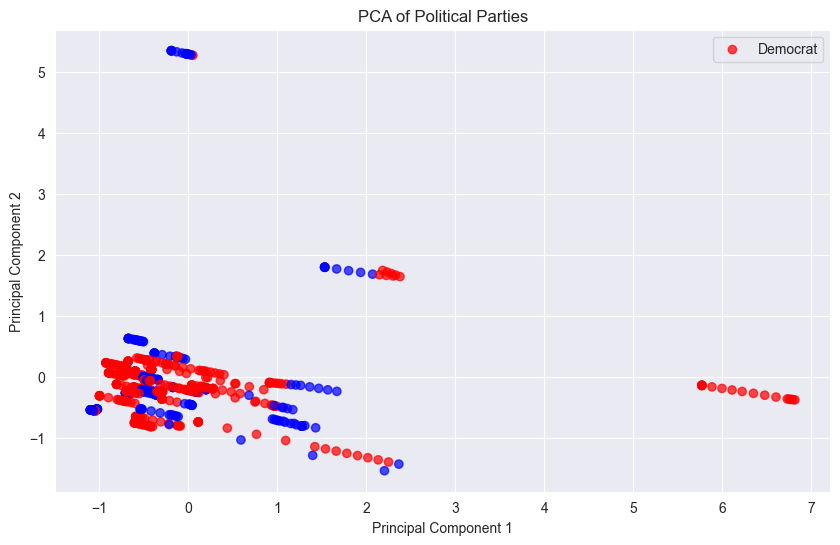

Accuracy: 0.6391096979332274


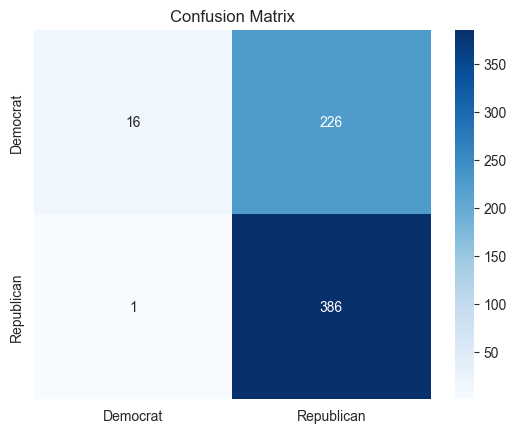

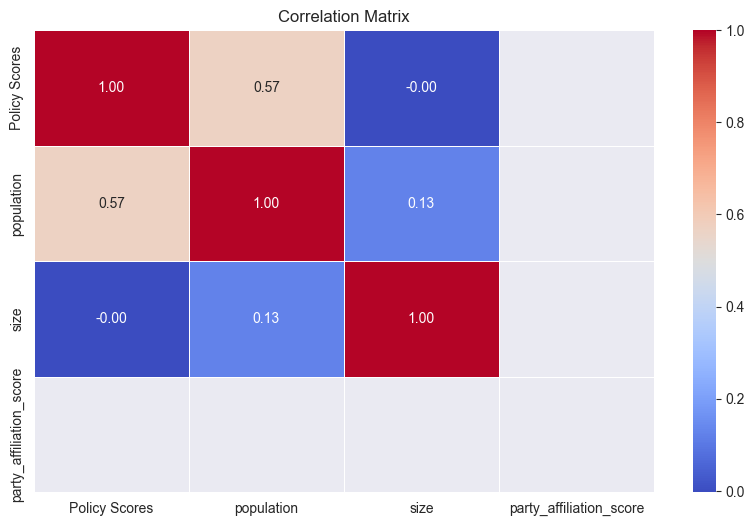

                   Feature       VIF
0                    const  1.000000
1            Policy Scores  1.485577
2               population  1.509379
3                     size  1.024433
4  party_affiliation_score       NaN


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [50]:
analyze_political_party(without_party_score_df)